## Clustering on Graph Dataset

In [ ]:
import networkx as nx
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import seaborn as sns
from stellargraph.data import UniformRandomMetaPathWalk
from stellargraph import StellarGraph
from gensim.models import Word2Vec
from sklearn.cluster import KMeans

In [ ]:
data=pd.read_csv("/content/drive/My Drive/Copy of movie_actor_network.csv", index_col=False, names=['movie','actor'])

In [ ]:
edges = [tuple(x) for x in data.values.tolist()]

In [ ]:
B = nx.Graph()
B.add_nodes_from(data['movie'].unique(), bipartite=0, label='movie')
B.add_nodes_from(data['actor'].unique(), bipartite=1, label='actor')
B.add_edges_from(edges, label='acted')

In [ ]:
A = (B.subgraph(c) for c in nx.connected_components(B))
A = list(A)[0]

In [ ]:
print("number of nodes", A.number_of_nodes())
print("number of edges", A.number_of_edges())

number of nodes 4703
number of edges 9650


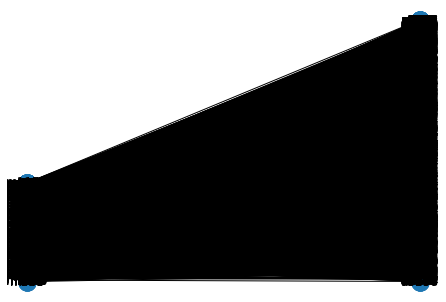

In [ ]:
l, r = nx.bipartite.sets(A)
pos = {}

pos.update((node, (1, index)) for index, node in enumerate(l))
pos.update((node, (2, index)) for index, node in enumerate(r))
  
nx.draw(A, pos=pos, with_labels=True)
plt.show()

In [ ]:
movies = []
actors = []
for i in A.nodes():
    if 'm' in i:
        movies.append(i)
    if 'a' in i:
        actors.append(i)
print('number of movies ', len(movies))
print('number of actors ', len(actors))

number of movies  1292
number of actors  3411


In [ ]:
# Create the random walker
rw = UniformRandomMetaPathWalk(StellarGraph(A))

# specify the metapath schemas as a list of lists of node types.
metapaths = [
    ["movie", "actor", "movie"],
    ["actor", "movie", "actor"]
]

walks = rw.run(nodes=list(A.nodes()), # root nodes
               length=100,  # maximum length of a random walk
               n=1,        # number of random walks per root node 
               metapaths=metapaths
              )

print("Number of random walks: {}".format(len(walks)))

Number of random walks: 4703


In [ ]:
model = Word2Vec(walks, size=128, window=5)

In [ ]:
model.wv.vectors.shape 

(4703, 128)

In [ ]:
# Retrieve node embeddings and corresponding subjects
node_ids = model.wv.index2word  # list of node IDs
node_embeddings = model.wv.vectors  # numpy.ndarray of size number of nodes times embeddings dimensionality
node_targets = [ A.nodes[node_id]['label'] for node_id in node_ids]

In [ ]:
def data_split(node_ids,node_targets,node_embeddings):
    '''In this function, we will split the node embeddings into actor_embeddings , movie_embeddings '''
    actor_nodes,movie_nodes=[],[]
    actor_embeddings,movie_embeddings=[],[]
    for i in range(len(node_targets)):
        if node_targets[i]=='actor':
            actor_embeddings.append(node_embeddings[i])         #splitting the nodes 
            actor_nodes.append(node_ids[i])
        if node_targets[i]=='movie':
            movie_embeddings.append(node_embeddings[i]) 
            movie_nodes.append(node_ids[i])
    return actor_nodes,movie_nodes,actor_embeddings,movie_embeddings

In [ ]:
actor_nodes,movie_nodes,actor_embeddings,movie_embeddings=data_split(node_ids,node_targets,node_embeddings)

<font color='cyan'>Grader function - 1</font>

In [ ]:
def grader_actors(data):
    assert(len(data)==3411)
    return True
grader_actors(actor_nodes)

True

<font color='cyan'>Grader function - 2</font>

In [ ]:
def grader_movies(data):
    assert(len(data)==1292)
    return True
grader_movies(movie_nodes)

True

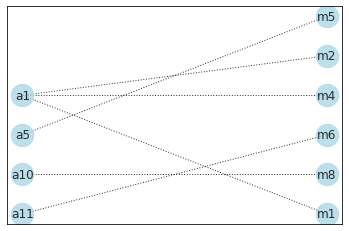

In [ ]:
import networkx as nx
from networkx.algorithms import bipartite
graded_graph= nx.Graph()
graded_graph.add_nodes_from(['a1','a5','a10','a11'], bipartite=0) # Add the node attribute "bipartite"
graded_graph.add_nodes_from(['m1','m2','m4','m6','m5','m8'], bipartite=1)
graded_graph.add_edges_from([('a1','m1'),('a1','m2'),('a1','m4'),('a11','m6'),('a5','m5'),('a10','m8')])
l={'a1','a5','a10','a11'};r={'m1','m2','m4','m6','m5','m8'}
pos = {}
pos.update((node, (1, index)) for index, node in enumerate(l))
pos.update((node, (2, index)) for index, node in enumerate(r))
nx.draw_networkx(graded_graph, pos=pos, with_labels=True,node_color='lightblue',alpha=0.8,style='dotted',node_size=500)

#### Cost1

In [ ]:
def cost1(graph,number_of_clusters):
    sb = sorted(nx.connected_components(graph), key=len, reverse=True)
    cc = graph.subgraph(sb[0])
    
    cost1= (1/number_of_clusters)*(cc.number_of_nodes()/len(graph.nodes()))
    
    return cost1

<font color='cyan'>Grader function - 3</font>

In [ ]:
graded_cost1=cost1(graded_graph,3)
def grader_cost1(data):
    assert(data==((1/3)*(4/10))) # 1/3 is number of clusters
    return True
grader_cost1(graded_cost1)

True

#### Cost2

In [ ]:
def cost2(graph,number_of_clusters):
    f=0
    anod=[]
    mnod=set()
    for k in graph:
        if 'a' in k:
            anod.append(k)  
    for i in anod:
        f+=graph.degree(i)   # sum of degrees of actor nodes
    for j in graph:
        if 'm' in j:      # unique movie nodes
            mnod.add(j)

    cost2= (1/number_of_clusters)*(f/len(mnod))
    
    return cost2

<font color='cyan'>Grader function - 4</font>

In [ ]:
graded_cost2=cost2(graded_graph,3)
def grader_cost2(data):
    assert(data==((1/3)*(6/6))) # 1/3 is number of clusters
    return True
grader_cost2(graded_cost2)

True

### Actor Nodes

In [ ]:
ar=[]
for i in actor_embeddings:
    c=i.tolist()
    ar.append(c)          #converting actor_embeddings in to matrix of shape (3411,128)

actor_matrix=np.asarray(ar)

In [ ]:
actor_matrix.shape

(3411, 128)

In [ ]:
clust = [3,5, 10, 30, 50, 100, 200, 500]
def clusterform(data,type_nodes,cluster):
   
    ttcost=[]
    for i in range(len(cluster)):
        algo=KMeans(n_clusters=cluster[i], random_state=0)  #applying Kmeans on data
        algo.fit(data)
        j=algo.labels_
        co=zip(type_nodes,j)       # combining respective nodes with the labels
        comb=list(co)

        box=[]
        for k in range(cluster[i]):         # creating emptly lists to store similar labels
            box.append([])

        for j in range(cluster[i]):
            for r in comb:
                if r[1]==j:                   # storing similar labels 
                    box[j].append(r[0]) 
        actcost1=0
        actcost2=0
    
        for v in box:
            B1 = nx.Graph()                  # Initiating empty graph
            for p in v:
                c=nx.ego_graph(A,p)
                B1.add_nodes_from(c.nodes)       # adding nodes and edges to graph 
                B1.add_edges_from(c.edges())
            actcost1+=cost1(B1,cluster[i])        # calculating cost1 and cost2
            actcost2+=cost2(B1,cluster[i])

        totalcost=(actcost1*actcost2)            # Calculating total cost
        ttcost.append(totalcost)
        print("the total cost for",cluster[i],"clusters",totalcost)
    big=ttcost.index(max(ttcost))                 # Getting the cluster with highest cost 
    max_clust=cluster[big]
 
    print("The cluster With max Cost=",max_clust)
    return max_clust

In [ ]:
max_actor=clusterform(actor_matrix,actor_nodes,clust)

the total cost for 3 clusters 3.7925789428287184
the total cost for 5 clusters 2.8100937362077727
the total cost for 10 clusters 2.375475432140978
the total cost for 30 clusters 1.6865972241189406
the total cost for 50 clusters 1.6098273540432653
the total cost for 100 clusters 1.5175726628203094
the total cost for 200 clusters 1.7570709613437414
the total cost for 500 clusters 1.8311602517454464
The cluster With max Cost= 3


#### Labels for each node

In [ ]:
kmodel=KMeans(n_clusters=max_actor, random_state=0) 
kmodel.fit(actor_matrix)
pred=kmodel.predict(actor_matrix)

#### Performing dimensionality reduction

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
actmodel = TSNE(n_components=2, random_state=0)
act_red = actmodel.fit_transform(actor_matrix)

In [ ]:
stack_data=np.vstack((act_red .T,pred )).T
stack_data.shape

(3411, 3)

In [ ]:
actor_df = pd.DataFrame(data=stack_data, columns=("Dim_1", "Dim_2", "label"))

In [ ]:
actor_df.head()

,Dim_1,Dim_2,label
0,-47.294632,-43.465271,1.0
1,-42.677341,-47.419064,1.0
2,-47.394371,-44.007877,1.0
3,45.249214,-36.831120,2.0
4,-39.064537,-47.726528,1.0


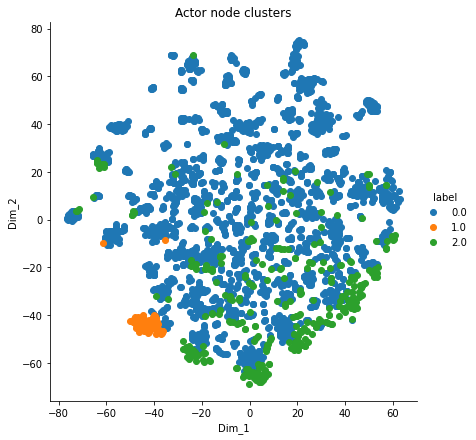

In [ ]:
sns.FacetGrid(actor_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('Actor node clusters')
plt.show()

#### Movie nodes

In [ ]:
mov=[]
for i in movie_embeddings:
    c=i.tolist()
    mov.append(c)

movie_matrix=np.asarray(mov)

In [ ]:
movie_matrix.shape

(1292, 128)

In [ ]:
def cost2(graph,number_of_clusters):
    f=0
    anod=[]
    mnod=set()
    for k in graph:
        if 'm' in k:
            anod.append(k)
    for i in anod:
        f+=graph.degree(i)
    for j in graph:
        if 'a' in j:
            mnod.add(j)

    cost2= (1/number_of_clusters)*(f/len(mnod))
    
    return cost2

In [ ]:
max_movie=clusterform(movie_matrix,movie_nodes,clust)

the total cost for 3 clusters 2.780393893109941
the total cost for 5 clusters 2.4206969765472115
the total cost for 10 clusters 2.5545136608203975
the total cost for 30 clusters 2.0965308141443164
the total cost for 50 clusters 1.8346751318298329
the total cost for 100 clusters 1.5557677561570187
the total cost for 200 clusters 1.364728046356718
the total cost for 500 clusters 1.2070805971486243
The cluster With max Cost= 3


In [ ]:
kmodel1=KMeans(n_clusters=max_movie, random_state=0)
kmodel1.fit(movie_matrix)
pred1=kmodel1.predict(movie_matrix)

In [ ]:
movmodel = TSNE(n_components=2, random_state=0)
mov_pred = movmodel.fit_transform(movie_matrix)

In [ ]:
stack_data1=np.vstack((mov_pred .T,pred1)).T
stack_data1.shape

(1292, 3)

In [ ]:
movie_df = pd.DataFrame(data=stack_data1, columns=("Dim_1", "Dim_2", "label"))

In [ ]:
movie_df.head()

,Dim_1,Dim_2,label
0,22.402277,-6.511956,1.0
1,32.856472,17.013208,1.0
2,23.921610,-3.500080,1.0
3,9.109491,18.772274,1.0
4,23.147776,-2.725813,1.0


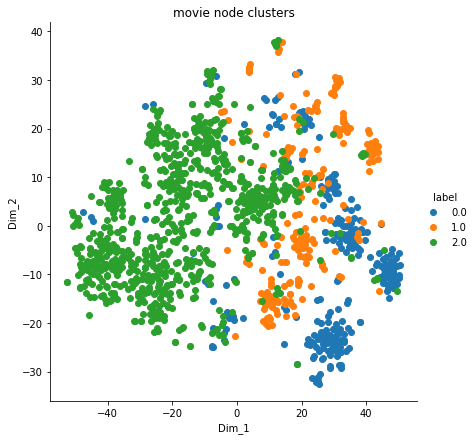

In [ ]:
sns.FacetGrid(movie_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('movie node clusters')
plt.show()